# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [355]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [356]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

In [357]:
#алтернативный способ подключения
url = 'https://drive.google.com/file/d/1NssWzVsRADr_EhDhZR9iE3Jo6guq3uYB/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
12075,18445,63397,"England, United Kingdom",21-03-2020,@MarcS1503 Why the fuck should I ? They've bee...,Extremely Negative
6635,11861,56813,Bankside,19-03-2020,Coronavirus: Minister says there 'isn't a shor...,Extremely Negative
2975,7403,52355,"New York, NY",18-03-2020,"This data is evolving quickly, so we will be p...",Positive
25715,35299,80251,NaN,06-04-2020,Pandemic profiteers run up prices on masks for...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [358]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ['Positive', 'Extremely Positive'] else 0)

Сбалансированы ли классы?

In [359]:
df['Sentiment'].value_counts()

,count
Sentiment,
1,18046
0,15398


Да, они сбалансированы.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [360]:
# посмотрим есть ли пропуски
df.isna().sum()

,0
UserName,0
ScreenName,0
Location,7049
TweetAt,0
OriginalTweet,0
Sentiment,0


In [361]:
# пропуски имеются для Location заполним их
df.fillna('Unknown', inplace=True)

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [362]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [363]:
from collections import Counter

tokens = []

for tweet in train['OriginalTweet']:
    tokens.extend(tweet.lower().split())

token_counts = Counter(tokens)
token_counts

Counter({'why': 654,
         'we': 3787,
         'still': 763,
         'want': 487,
         'to': 23373,
         'buy': 748,
         'so': 1837,
         'much': 482,
         'stuff': 106,
         'during': 1908,
         'quarantine': 154,
         'https://t.co/1m881cwfuv': 1,
         '#shopping': 121,
         '#covid_19': 1660,
         '#online': 40,
         'with': 4063,
         'driving': 77,
         'even': 682,
         'more': 2008,
         'usage': 22,
         'a': 11737,
         'strong': 93,
         'strategy': 33,
         'is': 7383,
         'critical': 156,
         'now': 1349,
         'then': 435,
         'ever': 179,
         'luckily': 8,
         'and': 14684,
         'april': 163,
         '16': 36,
         'webinar': 65,
         'will': 2726,
         'dive': 10,
         'into': 666,
         'growing': 84,
         'app': 52,
         'awareness': 32,
         'targeting': 9,
         'high': 408,
         'lifetime': 4,
         'value': 

Какой размер словаря получился?

In [364]:
print(f'Размер словаря: {len(tokens)}')

Размер словаря: 754630


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [365]:
token_counts.most_common(10)

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** все эти токены являются просто предлогами, артиклями и тому подобное. Они присутствуют почти в каждом твите. Исключение это #coronavirus, но это и логично, что в твитах про коронавирус есть такой хэштег.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [366]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

filtered_tokens = [token for token in tokens if token not in stop_words]

filtered_tokens_count = Counter(filtered_tokens)
print('Топ 10 токенов после удаления stop_words:')
print(filtered_tokens_count.most_common(10))

Топ 10 токенов после удаления stop_words:
[('#coronavirus', 8223), ('prices', 3891), ('food', 3820), ('grocery', 3469), ('supermarket', 3288), ('people', 3175), ('covid-19', 3173), ('store', 3155), ('#covid19', 2471), ('&amp;', 2314)]


**Ответ:**  он изменился, все предлоги, артикли и т.п. пропали. Теперь можно увидить слова, которые доносят смысл того, о чем написано в твитах. Тут присутсвуют названия самого вируса + что-то связанное с ценами на продукты и магазинами.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [367]:
filtered_tokens_count.most_common()[:-21:-1]

[('https://t.co/7j2y3rsld9', 1),
 ('@680news', 1),
 ('@torontopearson', 1),
 ('nothing...', 1),
 ('flew', 1),
 ('wage!', 1),
 ('renewing', 1),
 ('playersâ\x92', 1),
 ('subsidise', 1),
 ('non-playing', 1),
 ('premiership', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('#southkerry', 1),
 ('#skelligcoast2kms', 1),
 ('@skelligsix18', 1),
 ('closer!)', 1),
 ('coast!', 1),
 ('skellig', 1)]

**Ответ:** тут есть ссылки, понятно, что они редко встречаются + еще везде разные, поэтому лучше это убрать из текста, они не несут смысла. Также есть слова со знаками препинания, они не популярны в силу того, что какое-то слово хоть и могло встречатся много раз в тексте, но тут получилось так, что оно было написано со знаком препинания один раз. Это тоже надо поправить.




Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [368]:
from nltk.tokenize import TweetTokenizer

tweet_tokens = []
tw = TweetTokenizer()

for text in train['OriginalTweet']:
  tweet_tokens.extend(tw.tokenize(text))

tweet_tokens_count = Counter(tweet_tokens)
tweet_tokens_count.most_common(10)

[('the', 24337),
 ('.', 24118),
 ('to', 22933),
 (',', 17571),
 ('and', 14354),
 ('of', 12904),
 ('a', 11045),
 ('in', 10573),
 ('?', 9524),
 ('for', 8228)]

**Ответ:** tweet tokenizer не убирает знаки препинания и стоп-слова, поэтому тут в топе и находятся артикли, предлоги, знаки препинания. Но это отличается от того, где мы просто делали split, так как там знаки препинания не отделяются от слов, поэтому там топ был другой (знаки препинания просто были приклеены к словам, ну а тут уже много разных комбинаций и они различны).

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [369]:
from string import punctuation

stop_words = set(stopwords.words('english'))
punctuation = set(punctuation)

filtered_tweet_tokens = [t for t in tweet_tokens if t not in stop_words and t not in punctuation]

filtered_tweet_tokens_count = Counter(filtered_tweet_tokens)
filtered_tweet_tokens_count.most_common(10)

[('19', 7167),
 ('#coronavirus', 7143),
 ('I', 5235),
 ('\x92', 4372),
 ('prices', 4281),
 ('COVID', 4218),
 ('food', 3795),
 ('store', 3691),
 ('supermarket', 3373),
 ('grocery', 3083)]

**Ответ:** да, есть странные символы по типу \x92, это тоже надо убирать.

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [370]:
new_filtered_tweet_tokens = [t for t in filtered_tweet_tokens if not (len(t) == 1 and ord(t) >= 128)]

In [371]:
new_filtered_tweet_tokens_count = Counter(new_filtered_tweet_tokens)
new_filtered_tweet_tokens_count.most_common(10)

[('19', 7167),
 ('#coronavirus', 7143),
 ('I', 5235),
 ('prices', 4281),
 ('COVID', 4218),
 ('food', 3795),
 ('store', 3691),
 ('supermarket', 3373),
 ('grocery', 3083),
 ('people', 3047)]

In [372]:
new_filtered_tweet_tokens_count.most_common()[:-21:-1]

[('https://t.co/7j2Y3rSld9', 1),
 ('@680NEWS', 1),
 ('@TorontoPearson', 1),
 ('flew', 1),
 ('renewing', 1),
 ('playersÂ', 1),
 ('subsidise', 1),
 ('non-playing', 1),
 ('premiership', 1),
 ('Vile', 1),
 ('https://t.co/IAEK4fWsgz', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/zJcL195VQS', 1),
 ('#SouthKerry', 1),
 ('#SkelligCoast2kms', 1),
 ('@SkelligSix18', 1),
 ('Skellig', 1),
 ('milion', 1),
 ('now.When', 1),
 ('ruins', 1)]

**Ответ:** топ 10 стал содержать слова со смыслом, а вот из 20 самых непопулярных пропали всякие слова совместно со знаками препинания, но тут до сих пор есть ссылки и какие-то странные слова.

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [373]:
hashtags = [t for t in new_filtered_tweet_tokens if t.startswith('#')]

In [374]:
Counter(hashtags).most_common(10)

[('#coronavirus', 7143),
 ('#COVID19', 1844),
 ('#Covid_19', 1463),
 ('#Coronavirus', 1281),
 ('#COVID2019', 927),
 ('#toiletpaper', 657),
 ('#covid19', 568),
 ('#COVID', 542),
 ('#CoronaCrisis', 426),
 ('#CoronaVirus', 351)]

**Ответ:** все хештеги есть вариации слова коронавирус, кроме toiletpaper.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [375]:
links = [t for t in new_filtered_tweet_tokens if t.startswith('https://t.co')]
Counter(links).most_common(10)

[('https://t.co/oXA7SWtoNd', 5),
 ('https://t.co/gP3EusapL8', 4),
 ('https://t.co/DefTruI1PfÂ', 3),
 ('https://t.co/WrLHYzIzAA', 3),
 ('https://t.co/kuwIpF1KQW', 3),
 ('https://t.co/zjNRx6dKKN', 3),
 ('https://t.co/3GBBDpdjat', 3),
 ('https://t.co/e2ZNXajPre', 3),
 ('https://t.co/CATKegAyOY', 3),
 ('https://t.co/G63RP042HO', 3)]

**Ответ:** ссылки редко использовались одинаковые, их популярность не сравнима с популярностью хештегов. Информация о ссылке на конкретную страницу навряд ли будет полезна для нашей задачи - оценки тональности текста.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [376]:
tw_tokenizer = TweetTokenizer()
noise = set(stopwords.words('english')) | set(punctuation)

def custom_tokenizer(text):
  text = text.lower()
  tmp_tokens = []
  tmp_tokens.extend(tw_tokenizer.tokenize(text))
  tokens = [t for t in tmp_tokens if t not in noise and not t.startswith('https://t.co') and not (len(t) == 1 and ord(t) >= 128)]
  return tokens

In [377]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [378]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)

x_train = cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45300


**Ответ:** он стал меньше, ведь мы убрали стоп слова, пунктуацию и т. д.

Посмотрим на какой-нибудь конкретный твитт:

In [379]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [380]:
vector = cv.transform([train.iloc[ind]['OriginalTweet']])
vector = vector.toarray()[0]
non_zero_indexes = vector.nonzero()[0]
non_zero_values = vector[non_zero_indexes]
max_idx = non_zero_indexes[non_zero_values.argmax()]
min_idx = non_zero_indexes[non_zero_values.argmin()]
inv_vocab = {i: t for t, i in cv.vocabulary_.items()}
max_token = inv_vocab[max_idx]
min_token = inv_vocab[min_idx]
print(f"Самый важный токен (частота={vector[max_idx]}): {max_token}")
print(f"Самый неважный токен (частота={vector[min_idx]}): {min_token}")

Самый важный токен (частота=1): #coronavirusoutbreak
Самый неважный токен (частота=1): #coronavirusoutbreak


**Ответ:** нет ничего не получилось, ведь он просто посчитал количество слов, а тут каждое слово встречается один раз

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [381]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)

tfidf_vec.fit_transform(train['OriginalTweet'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 443009 stored elements and shape (23410, 45300)>

In [382]:
vector = tfidf_vec.transform([train.iloc[ind]['OriginalTweet']])
vector = vector.toarray()[0]
non_zero_indexes = vector.nonzero()[0]
non_zero_values = vector[non_zero_indexes]
max_idx = non_zero_indexes[non_zero_values.argmax()]
min_idx = non_zero_indexes[non_zero_values.argmin()]
inv_vocab = {i: t for t, i in cv.vocabulary_.items()}
max_token = inv_vocab[max_idx]
min_token = inv_vocab[min_idx]
print(f"Самый важный токен (частота={vector[max_idx]}): {max_token}")
print(f"Самый неважный токен (частота={vector[min_idx]}): {min_token}")

Самый важный токен (частота=0.3867641170466375): brainless
Самый неважный токен (частота=0.11328893069250721): food


**Ответ:** самый частый токен хорошо определился. Это brainless, что в принципе отражает негативное отношение автора, ну а самый не важный food. Так произошло, потому что TfidfVectorizer учитывает нетолько частоту слова в одном тексте, но он рассматривает и все другие. Если в других оно встречалось реже, то для этого текста оно будет важнее.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [383]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) Â Meeting the need of h...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [384]:
ind = 8221
train.loc[ind]['OriginalTweet']

'Let s just take a minute to say THANK YOU also to the amazing postal workers So many real people behind a click of online shopping and getting cards delivered Thank   you   19'

In [385]:
vector = tfidf_vec.transform([train.loc[ind]['OriginalTweet']])
vector = vector.toarray()[0]
non_zero_indexes = vector.nonzero()[0]
non_zero_values = vector[non_zero_indexes]
max_idx = non_zero_indexes[non_zero_values.argmax()]
min_idx = non_zero_indexes[non_zero_values.argmin()]
inv_vocab = {i: t for t, i in cv.vocabulary_.items()}
max_token = inv_vocab[max_idx]
min_token = inv_vocab[min_idx]
print(f"Самый важный токен (частота={vector[max_idx]}): {max_token}")
print(f"Самый неважный токен (частота={vector[min_idx]}): {min_token}")

Самый важный токен (частота=0.3691299729428482): thank
Самый неважный токен (частота=0.08634631973114962): 19


**Ответ:** по слову thank можно понять, что кто-то кого-то благодорит и что этот твит имеет скорее всего положительный окрас.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [386]:
vec = CountVectorizer(tokenizer=custom_tokenizer)
x_train_vec = vec.fit_transform(train['OriginalTweet'])
x_test_vec = vec.transform(test['OriginalTweet'])

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
x_train_tfidf = tfidf_vec.fit_transform(train['OriginalTweet'])
x_test_tfidf = tfidf_vec.transform(test['OriginalTweet'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [387]:
y_train = train['Sentiment']
y_test = test['Sentiment']

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [388]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [389]:
log_reg_cv = LogisticRegression()
log_reg_cv.fit(x_train_vec, y_train)
accuracy_train_cv = accuracy_score(y_train, log_reg_cv.predict(x_train_vec))
accuracy_test_cv = accuracy_score(y_test, log_reg_cv.predict(x_test_vec))
print(f'CountVectorizer доля правильных ответов на обучающей выборке: {accuracy_train_cv}, на тестовой: {accuracy_test_cv}')

CountVectorizer доля правильных ответов на обучающей выборке: 0.9844510892780863, на тестовой: 0.8675503288818018


In [390]:
log_reg_tfdif = LogisticRegression()
log_reg_tfdif.fit(x_train_tfidf, y_train)
accuracy_train_tdfid = accuracy_score(y_train, log_reg_tfdif.predict(x_train_tfidf))
accuracy_test_tfdif = accuracy_score(y_test, log_reg_tfdif.predict(x_test_tfidf))
print(f'TfdifVectorizer доля правильных ответов на обучающей выборке: {accuracy_train_tdfid}, на тестовой: {accuracy_test_tfdif}')

TfdifVectorizer доля правильных ответов на обучающей выборке: 0.9225117471166169, на тестовой: 0.8527008172214471


**Ответ:** На обучающей выборке у CountVectorizer доля правильных отеветов больше, чем у TfdifVectorizer, и близка к 1, что может говорить о переобучении. А на тестовой выборке доля правильных ответов почти одинаковая.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [391]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def custom_stem_tokenizer(text):
  text = text.lower()
  tmp_tokens = []
  tmp_tokens.extend(tw_tokenizer.tokenize(text))
  tokens = [stemmer.stem(t) for t in tmp_tokens if t not in noise and not t.startswith('https://t.co') and not (len(t) == 1 and ord(t) >= 128)]
  return tokens

In [392]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [393]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
x_train_vec = cv.fit_transform(train['OriginalTweet'])
x_test_vec = cv.transform(test['OriginalTweet'])
print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36644


In [394]:
tfdif_vec = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
x_train_tfidf = tfdif_vec.fit_transform(train['OriginalTweet'])
x_test_tfidf = tfdif_vec.transform(test['OriginalTweet'])
print(len(tfdif_vec.vocabulary_))

36644


**Ответ** Размер словаря уменьшился приблизительно на 10000.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [395]:
log_reg_cv = LogisticRegression()
log_reg_cv.fit(x_train_vec, y_train)
accuracy_train_cv = accuracy_score(y_train, log_reg_cv.predict(x_train_vec))
accuracy_test_cv = accuracy_score(y_test, log_reg_cv.predict(x_test_vec))
print(f'CountVectorizer доля правильных ответов на обучающей выборке: {accuracy_train_cv}, на тестовой: {accuracy_test_cv}')

CountVectorizer доля правильных ответов на обучающей выборке: 0.9718923536950022, на тестовой: 0.8673510065776361


In [396]:
log_reg_tfdif = LogisticRegression()
log_reg_tfdif.fit(x_train_tfidf, y_train)
accuracy_train_tdfid = accuracy_score(y_train, log_reg_tfdif.predict(x_train_tfidf))
accuracy_test_tfdif = accuracy_score(y_test, log_reg_tfdif.predict(x_test_tfidf))
print(f'TfdifVectorizer доля правильных ответов на обучающей выборке: {accuracy_train_tdfid}, на тестовой: {accuracy_test_tfdif}')

TfdifVectorizer доля правильных ответов на обучающей выборке: 0.9159333618111918, на тестовой: 0.8566872633047639


**Ответ:** почти ничего не изменилось, имеет смысл использовать стемминг только для оптимизации. На 10000 уменьшился размер признакового пространства.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [397]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.3
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36643


**Ответ:** у меня изначально было 36644, и получилось, что при max_df=0.3 можео добится уменьшения размера словаря на 1. То есть мы игнорируем все слова, которые встречаются в более чем 30% твитов. Получается: таких слов было мало.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [398]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3687


In [399]:
x_train = cv_df.transform(train['OriginalTweet'])
x_test = cv_df.transform(test['OriginalTweet'])
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
accuracy_train_cv = accuracy_score(y_train, log_reg.predict(x_train))
accuracy_test_cv = accuracy_score(y_test, log_reg.predict(x_test))
print(f'CountVectorizer доля правильных ответов на обучающей выборке: {accuracy_train_cv}, на тестовой: {accuracy_test_cv}')

CountVectorizer доля правильных ответов на обучающей выборке: 0.9290046988466467, на тестовой: 0.8680486346422165


**Ответ:** у нас полчилось то, что мы хотели, убрав редко встречающиеся слова, качество модели не изменилось, а значит они были не так важны. min_df=11, значит мы убрали те слова, которые встречаются меньше чем в 11 документах.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [400]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [401]:
log_reg = LogisticRegression(C=0.1)
log_reg.fit(x_train_scaled, y_train)
accuracy_train_cv = accuracy_score(y_train, log_reg.predict(x_train_scaled))
accuracy_test_cv = accuracy_score(y_test, log_reg.predict(x_test_scaled))
print(f'CountVectorizer доля правильных ответов на обучающей выборке: {accuracy_train_cv}, на тестовой: {accuracy_test_cv}')

CountVectorizer доля правильных ответов на обучающей выборке: 0.9408799658265699, на тестовой: 0.8474187761610524


In [402]:
feautures_names = np.array(cv_df.get_feature_names_out())
weights = log_reg.coef_[0]
top_pos_idx = np.argsort(weights)[-10:]
top_neg_ids = np.argsort(weights)[:10]

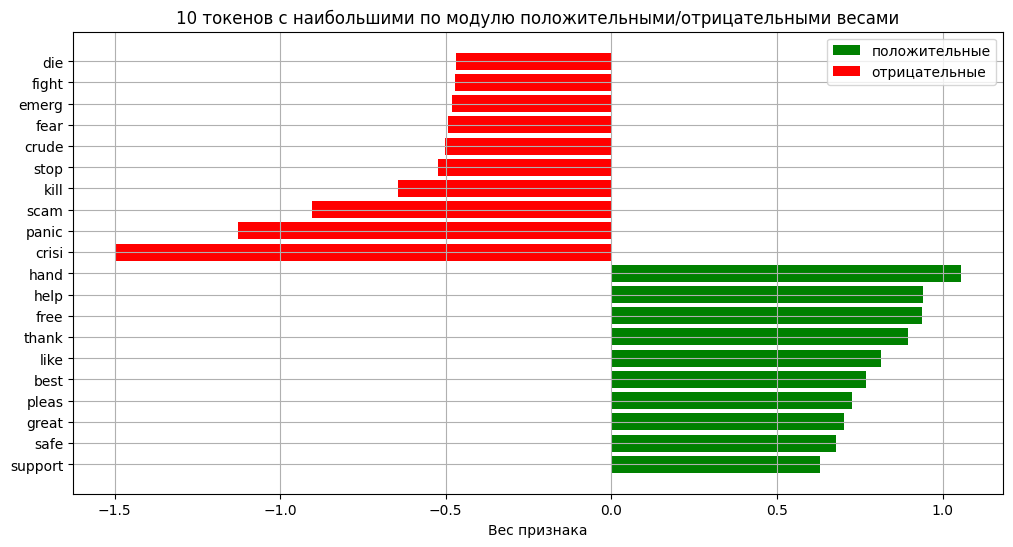

In [403]:
plt.figure(figsize=(12, 6))

plt.barh(feautures_names[top_pos_idx], weights[top_pos_idx], color='green', label='положительные')
plt.barh(feautures_names[top_neg_ids], weights[top_neg_ids], color='red', label='отрицательные')
plt.title('10 токенов с наибольшими по модулю положительными/отрицательными весами')
plt.grid(True)
plt.legend()
plt.xlabel('Вес признака')
plt.show()

**Ответ:** логистическая регрессия больше переобучилась, но все равно результаты несильно отличаются от предыдущих. А по токенам видно, что слова по типо помощь, лучший, замечательный, безопасный и т. д. имеют наибольшие положительные веса и "говорят" о том, что тональность твита положительная. Слова: смерть, страх и т. д. говорят о том, что твит скорее всего отрицательной окраски.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [404]:
# посмотрим, встречаются ли достаточно часто различные имена
train['UserName'].nunique()

23410

In [405]:
train.shape

(23410, 6)

In [406]:
train['ScreenName'].nunique()

23410

**Ответ:** видим, что у нас в обучающем наборе столько же имен сколько и самих объектов, то есть у каждого объекта уникальный User/Screen Name и это нам ничем не поможет для построения лучшей модели.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

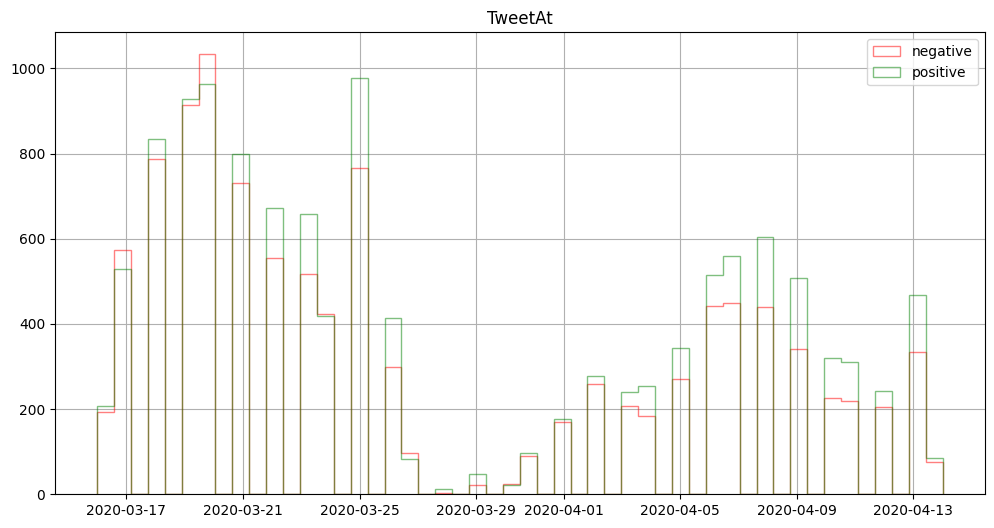

In [407]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], dayfirst=True)

plt.figure(figsize=(12, 6))
plt.hist(train[train['Sentiment'] == 0]['TweetAt'], color='red', alpha=0.5, label='negative', bins=50, histtype='step')
plt.hist(train[train['Sentiment'] == 1]['TweetAt'], color='green', alpha=0.5, label='positive', bins=50, histtype='step')
plt.legend()
plt.grid(True)
plt.title('TweetAt')
plt.show()

**Ответ:** видим, нет того времени, когда преимущественно были твиты одного время, да конечно, когда-то одного типа было больше, но это не так значительно.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [408]:
print(f'Уникальных значений Location в train: {train["Location"].nunique()}')

Уникальных значений Location в train: 7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

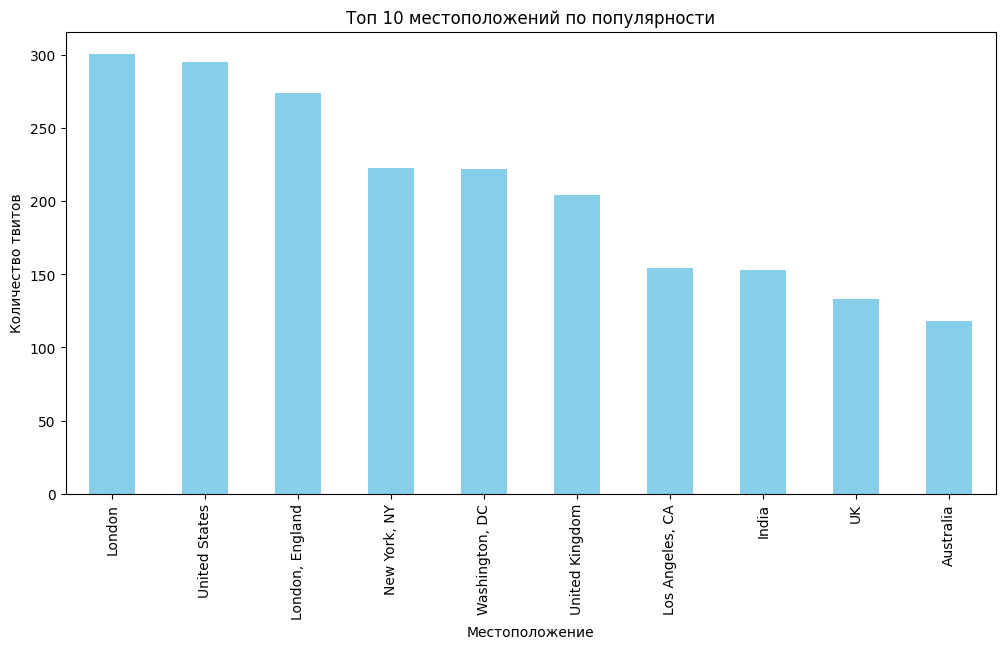

In [409]:
top_locations = train[train['Location'] != 'Unknown']['Location'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_locations.plot(kind='bar', color='skyblue')
plt.title('Топ 10 местоположений по популярности')
plt.xlabel('Местоположение')
plt.ylabel('Количество твитов')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [410]:
train['WiderLocation'] = train['Location'].apply(lambda l: l.split(',')[-1].strip())

In [411]:
print(f'Стало уникальных значений Location в train: {train["WiderLocation"].nunique()}')

Стало уникальных значений Location в train: 4631


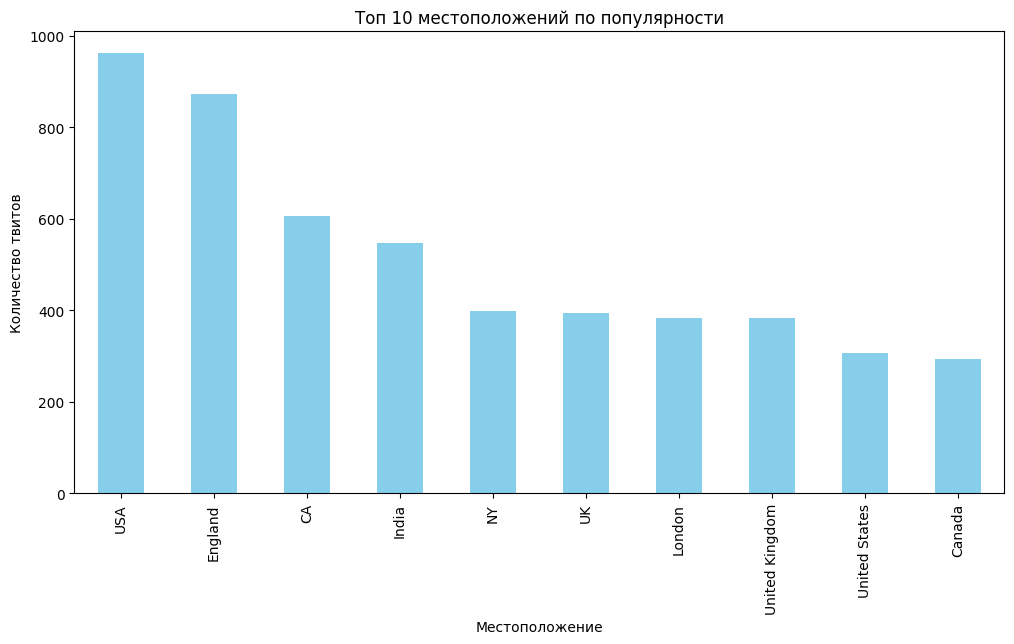

In [412]:
top_locations = train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_locations.plot(kind='bar', color='skyblue')
plt.title('Топ 10 местоположений по популярности')
plt.xlabel('Местоположение')
plt.ylabel('Количество твитов')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [413]:
test['WiderLocation'] = test['Location'].apply(lambda l: l.split(',')[-1].strip())

In [415]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', min_frequency=2, drop='first')
location_encoded_train = ohe.fit_transform(train[['WiderLocation']])
location_encoded_test = ohe.transform(test[['WiderLocation']])

print(f"Количество уникальных WiderLocation, встречающихся более одного раза: {location_encoded_train.shape[1]}")

Количество уникальных WiderLocation, встречающихся более одного раза: 988


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [416]:
from scipy.sparse import hstack

x_train_scaled = hstack([x_train_scaled, location_encoded_train])
x_test_scaled = hstack([x_test_scaled, location_encoded_test])

In [417]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(x_train_scaled, y_train)
accuracy_train = accuracy_score(y_train, log_reg.predict(x_train_scaled))
accuracy_test = accuracy_score(y_test, log_reg.predict(x_test_scaled))
print(f'Доля правильных ответов на обучающей выборке: {accuracy_train}')
print(f'Доля правильных ответов на тестовой выборке: {accuracy_test}')

Доля правильных ответов на обучающей выборке: 0.9456215292609996
Доля правильных ответов на тестовой выборке: 0.8440302969902332


**Ответ:** доля верных ответов не изменилась, но если посмотреть на то, у каких признаков самые большие веса, то можно увидеть, что в топе появились признаки из Location. Так что в принципе этот признак содержит полезную информацию, хотя без него качество тоже.

In [418]:
features_names = np.concatenate([cv_df.get_feature_names_out(), ohe.categories_[0]])
weights = log_reg.coef_[0]
top_pos_idx = np.argsort(weights)[-10:]
top_neg_ids = np.argsort(weights)[:10]

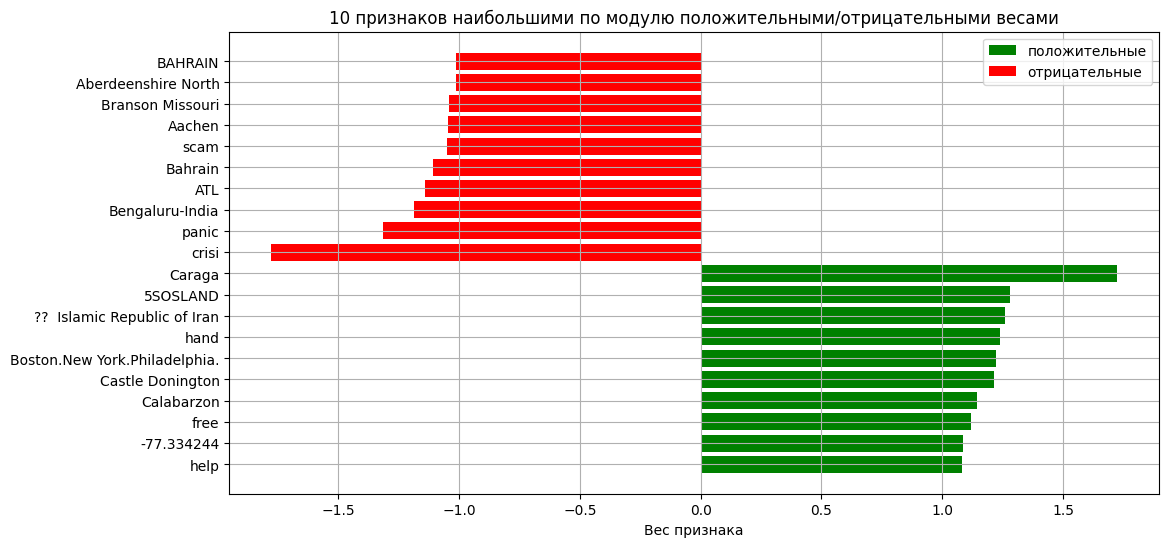

In [419]:
plt.figure(figsize=(12, 6))

plt.barh(features_names[top_pos_idx], weights[top_pos_idx], color='green', label='положительные')
plt.barh(features_names[top_neg_ids], weights[top_neg_ids], color='red', label='отрицательные')
plt.title('10 признаков наибольшими по модулю положительными/отрицательными весами')
plt.grid(True)
plt.legend()
plt.xlabel('Вес признака')
plt.show()